In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import gzip

In [123]:
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [124]:
ModCloth = pd.read_csv('data/ModCloth_clear.csv')
df = ModCloth[['user_id', 'item_id', 'quality']]
df.columns = ['user_id', 'item_id', 'rating']

df=df.head(10000)

reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df, reader)

# Find best values for hyperparameters

4it [00:14,  3.55s/it]


,cosine,msd,pearson,pearson_baseline
k,11.000000,21.000000,9.000000,22.000000
RMSE_k,0.986788,0.987528,0.976182,0.976079


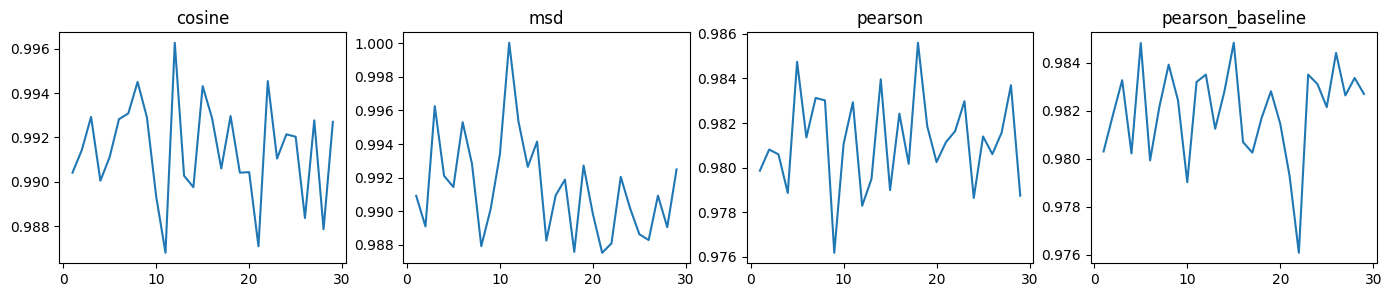

In [125]:
similarity = ['cosine', 'msd', 'pearson', 'pearson_baseline']
k_grid = np.arange(1,30) 
res = {}

fig = plt.figure(figsize = (17,3))

for pos,s in tqdm(enumerate(similarity)):
    RMSE = []
    for k in k_grid:
        sim_options = {
            "k": k,
            "name": s,
            "user_based": False, 
        }

        model = KNNBasic(sim_options = sim_options)

        results = cross_validate(model, data, measures=['RMSE'], cv=3, verbose=0, n_jobs=-1)
        RMSE.append(np.mean(results['test_rmse']))
        
    res[s] = (k_grid[np.argmin(RMSE)], min(RMSE))
    ax = fig.add_subplot(1,4, pos+1)
    ax.plot(k_grid,RMSE)
    ax.set_title(s)

    
results = pd.DataFrame(res, index=['k', 'RMSE_k'])
display(results)

best_k = int(results.loc['k'][np.argmin(results.loc['RMSE_k'])])
best_metric = results.columns[np.argmin(results.loc['RMSE_k'])]

In [88]:
# GridSerach
sim_options = {
    "name": ['cosine', 'msd', 'pearson', 'pearson_baseline'],
    "k": np.arange(1,40),
    "user_based": [False],
}

param_grid = {"sim_options": sim_options}
gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mse"], cv=3, joblib_verbose = 0, n_jobs=-1)
gs.fit(data)


print(gs.best_score)
print(gs.best_params["rmse"]["sim_options"])
print(gs.best_params["mse"]["sim_options"])


{'rmse': 0.9518392228512523, 'mse': 0.907164443408694}
{'name': 'cosine', 'k': 1, 'user_based': False}
{'name': 'cosine', 'k': 1, 'user_based': False}


# Train the model

In [90]:
def top_n_recommendation(model, user_id, ratings_df, complete_df, n_items):
    users_id = ratings_df["user_id"].unique()
    if user_id not in users_id:
        return('This users do not exist')
    items_id = ratings_df["item_id"].unique()
    item_ids_user = ratings_df.loc[df["user_id"] == user_id, "item_id"]
    item_ids_to_pred = np.setdiff1d(items_id, item_ids_user)

    test_set = [[user_id, movie_id, 3] for movie_id in item_ids_to_pred]

    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])
    print("Top {0} item recommendations for user {1}:".format(n_items, user_id))
    index_max = (-pred_ratings).argsort()[:n_items]
    for i in index_max:
        item_id = item_ids_to_pred[i]
        print(f'Item:{item_id}, category:{complete_df[complete_df["item_id"]==item_id]["category"].values[0]}, rating:{pred_ratings[i]}')

In [93]:
user = 395665
n_items = 5

top_n_recommendation(model, user, df, ModCloth, n_items)

Top 5 item recommendations for user 395665:
Item:124024, category:new, rating:4.081
Item:124124, category:new, rating:4.081
Item:124761, category:new, rating:4.081
Item:125353, category:new, rating:4.081
Item:125442, category:new, rating:4.081


In [126]:
all_users = df.user_id.unique()
all_users.sort()
all_items = df.item_id.unique()
all_items.sort()

trainset = data.build_full_trainset()

sim_options = {
    "k": best_k,
    "name": best_metric,
    "user_based": False, 
}
model = KNNBasic(sim_options = sim_options) 
model.fit(trainset)


test_set = [[user, item, 3] for user in tqdm(all_users) for item in all_items]
pred = model.test(test_set)
items_rating = [round(p.est,2) for p in tqdm(pred)]

rating_matrix = np.reshape(items_rating, (len(all_users), len(all_items)))
rating_dataframe = pd.DataFrame(rating_matrix, columns=all_items, index=all_users)
rating_dataframe

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


100%|██████████| 693500/693500 [00:02<00:00, 239677.69it/s]


,123373,124024,124124,124761,125353,125442,125602,126560,126885,127008,...,158308,158723,159706,159891,160625,161320,161514,161592,161789,162470
209,3.94,3.94,4.00,4.00,3.94,4.00,3.94,4.00,3.94,3.94,...,3.94,3.94,4.00,3.94,3.94,3.94,4.00,3.94,3.94,4.00
309,3.94,3.94,5.00,5.00,3.94,5.00,3.94,5.00,3.94,3.94,...,3.94,3.94,5.00,3.94,3.94,3.94,5.00,3.94,3.94,5.00
560,3.94,3.94,3.94,3.94,3.94,5.00,3.94,3.94,5.00,3.94,...,3.94,3.94,3.94,3.94,3.94,3.94,5.00,3.94,3.94,3.94
564,3.94,3.94,3.94,3.94,3.94,3.94,3.94,3.94,3.94,3.94,...,3.94,3.94,3.94,3.94,3.00,3.94,3.94,3.94,3.94,3.94
783,3.94,3.94,3.94,3.94,3.94,4.00,3.94,3.94,4.00,3.94,...,3.94,3.94,3.94,3.94,3.94,3.94,4.00,3.94,3.94,3.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999387,3.94,3.94,3.00,3.00,3.94,3.00,3.94,3.00,3.94,3.94,...,3.94,3.94,3.00,3.94,3.94,3.94,3.00,3.94,3.94,3.00
999674,3.94,3.94,3.94,3.94,3.94,5.00,3.94,5.00,5.00,3.94,...,3.94,3.94,3.94,3.94,3.94,3.94,5.00,5.00,3.94,3.94
999697,3.94,3.94,3.94,4.00,3.94,4.00,3.94,3.94,4.00,3.94,...,3.94,3.94,3.94,3.94,3.94,3.94,3.94,4.00,3.94,4.00
999923,3.94,3.94,3.94,3.94,3.94,5.00,3.94,3.94,5.00,3.94,...,3.94,3.94,3.94,3.94,3.94,3.94,5.00,3.94,3.94,3.94


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

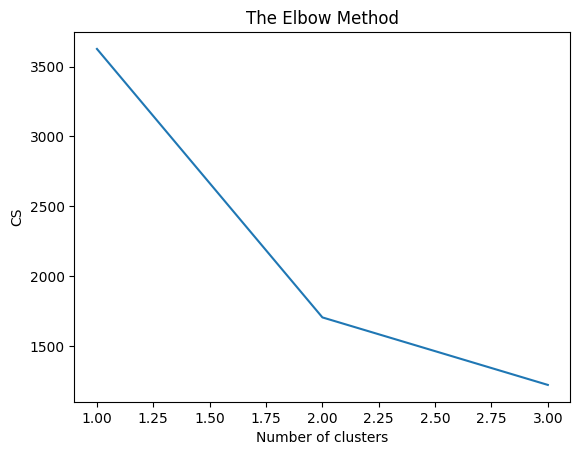

In [130]:
df_cosine=pd.DataFrame(cosine_similarity(rating_dataframe,dense_output=True))

cs = []
plt.figure(figsize=(10,6))
for i in range(1, 4):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_cosine)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 4), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

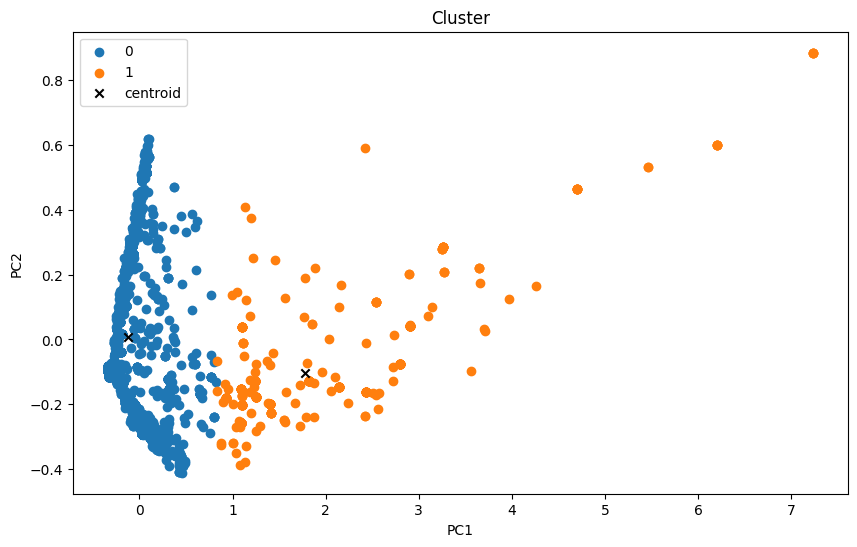

In [137]:
data = df_cosine
pca = PCA(2)
transform = pca.fit_transform(data)
kmeans = KMeans(n_clusters= 2)
label = kmeans.fit_predict(transform)
u_labels = np.unique(label)

plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='black',marker='x',label='centroid')
plt.legend()
plt.title('Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()